# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4: Линейные модели


###### <hr\>
**Общая информация**

**Срок сдачи:** 6 декабря 2017, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 6 декабря, -4 балла после 06:00 13 декабря, -6 баллов после 06:00 20 декабря

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.
<hr\>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

# Определям, что вам досталось

<center><img src='https://static1.squarespace.com/static/571a6e39b6aa608067028725/t/577988518419c2d62fb5922f/1467582555915/'></center>

Укажите свою фамилию на русском языке в поле ниже.

In [2]:
USER_NAME = u"Богомолов".lower()
REGULARIZATIONS = ["L1", "L2"]
ALGORITHM = ["", "Mini Batch"]

print "Имплементируйте обучение логистической регрессии с %s регуляризацией с помощью метода %s Stochastic Gradient Descent (SGD)"\
% (
    REGULARIZATIONS[hash(USER_NAME) % 2],
    ALGORITHM[hash(USER_NAME[::-1]) % 2]
)

Имплементируйте обучение логистической регрессии с L1 регуляризацией с помощью метода  Stochastic Gradient Descent (SGD)


#### Замечания
* В SGD градиент расчитывается по одному случайному объекту, т.е. в алгоритме надо
    * Перемешать выборку
    * Посчтитать градиент на одном объекте
    * Сделать шаг спуска
* В Mini Batch SGD - по подвыборке объектов т.е в алгоритме надо
    * Перемешать выборку
    * Разбить на части (примерно) одинакового размера - мини батчи
    * Почитать градиент по мини батчам
    * Сделать шаг спуска
* Сделайте убывающую скорость спуска, например `alpha/n_epoch` или `alpha/n_iter` или `alpha/n_batch` или ...
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации/батча/эпохи.
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в обучающей выборке (тем или иным способом)

### Примечание для случая L1-регуляризации:

При расчете производной по функции потерь
$$ L(w_0,w_1,\dots) = - \left[\sum_i y^{(i)}\log\left(1 - \sigma\left(g\left(x^{(i)}\right)\right)\right) + (1-y^{(i)})\log \sigma\left(g\left(x^{(i)}\right)\right)\right] + \frac{1}{C}\sum_{j=1}^{m}|w_j| $$
могут возникнуть сомнения по поводу производной части с модулями. 

Вам на выбор предлагаются следующией варианты:
* Считать субградиент $\partial|w_j| = sign(w_j)$ (проще, но с большой вероятностью не приведет к занулению коэффициентов)
* Метод SGD-Clipping из [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.1, страница 479, правая колонка снизу (чуть сложнее, но зато должно занулять)
* Cumulative Penalty из той же [статьи](https://www.aclweb.org/anthology/P/P09/P09-1054.pdf) - раздел 3.2

# Реализация модели

## Вывод правила обновления весов (1 балл)

Выведите правило обновления весов на каждом шаге алгоритма. Иными словами, посчитайте производную (градиент) функции потерь с регуляризацией. Формулы надо оформлять в формате LaTeX.

$$ \sigma'(x) = \sigma(x)\left(1 - \sigma(x)\right), \,\,g(x^{(i)}) = w_0 + x_1w_1 +\dots+x_jw_j+ \dots x_mw_m,$$
$$ \frac{\partial L}{\partial w_j} = -\sum_{i} \left(y^{(i)} - \sigma\left(g\left(x^{(i)}\right)\right)\right)x^{(i)}_j  + \dots. $$

## Имплементация (5 баллов)

In [2]:
def sigmoid(column):
    return 1./(1.+np.exp(-column))

In [34]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.errors = []
        
        
    def grad_L(self, X, y):
        """
        Gradient vector on all objects
        """ 
        N = X.shape[0]
        Xtmp = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
        g = np.dot(Xtmp, self.w.reshape(-1,1))
        tmp = (y.reshape(-1,1) - sigmoid(g))*Xtmp
        tmp = -np.sum(tmp, axis=0) + 1./self.C * np.sum(np.sign(self.w))
        return tmp
            
        
    def grad_Li(self, X_i, y_i):
        """
        Gradient vector on object i
        """ 
        N = X.shape[0]
        Xtmp = np.append(1.0, X_i)
        g = np.dot(Xtmp, self.w.reshape(-1,1))
        Xtmp = (y_i - sigmoid(g))*Xtmp
        res = -Xtmp + 1./self.C * np.sum(np.sign(self.w))
        return res
    
    def func_L(self, X,y):
        """
        Loss functional
        """

        Xtmp = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
        Xtmp = np.dot(Xtmp,self.w.reshape(-1,1))
        Xtmp = y.reshape(-1,1)*np.log(sigmoid(1. - Xtmp)) + (1-y.reshape(-1,1))*np.log(sigmoid(Xtmp))
        res = -np.sum(Xtmp) + 1./self.C * np.sum(np.abs(self.w))
        return res
            
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        N = X.shape[0]
        M = X.shape[1]
        self.w = 1./N * np.random.rand(1,M+1) - 1./N
        rand_indices = np.arange(N)
        
        for idx in xrange(self.max_epoch):
            #rand_idx = np.random.randint(N)
            for rand_idx in rand_indices:
                self.w = self.w - self.alpha * self.grad_Li(X[rand_idx,:], y[rand_idx])
            #self.w = self.w - self.alpha * self.grad_L(X, y)
            if N % (idx+1) == 0:
                self.alpha = self.alpha/2
            self.errors.append(self.func_L(X,y))
        return self
    
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        x = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
        pred = sigmoid(np.dot(x, self.w.reshape(-1,1)))
        y_hat = (pred > 0.5).astype(int)
   
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        x = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
        y_hat_proba = sigmoid(np.dot(x, self.w.reshape(-1,1)))
        return y_hat_proba

## Проверка на синтетических данных (1 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

In [35]:
model = MySGDClassifier(C=1000, max_epoch=100, alpha = 0.1)
model.fit(X,y)
w = model.w[0,1:]
w0 = model.w[0,0]
print(w0,w)

(-3.3481366078602322, array([ 0.81504136, -0.76379278]))


In [29]:
from sklearn.linear_model import SGDClassifier
model = SGDClassifier(loss='log', penalty='l1', alpha = 0.1)
model.fit(X,y)
w = model.coef_[0]
w0 = model.intercept_[0]
print(w0,w)

(-2.2027980472958002, array([ 0.68358742, -0.28235246]))


(2,)


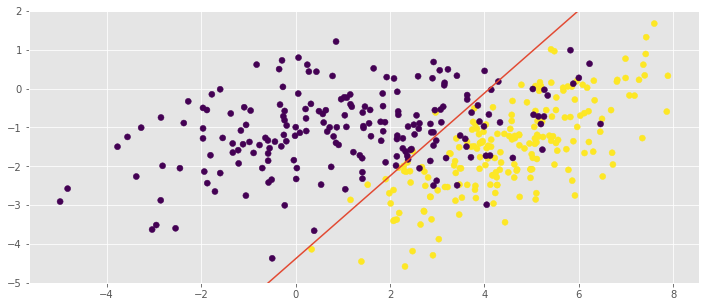

In [36]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

print(w.shape)
separ = lambda x: -w[0]/w[1] * x - w0/w[1]
#separ = lambda x: -w[0,1]/w[0,2] * x - w[0,0]/w[0,2]
tmp = np.arange(-5,8)
plt.scatter(X[:,0], X[:,1], c=y)
plt.ylim(-5, 2)
plt.plot(tmp, separ(tmp))

## Анализ сходимости (2 балла)

Для следующих заданий используйте датасет ниже

In [37]:
from sklearn.datasets import make_classification

In [38]:
X, y = make_classification(n_samples=100000, n_features=10, 
                           n_informative=4, n_redundant=0, 
                           random_state=123, class_sep=1.0,
                           n_clusters_per_class=1)

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/батча/эпохи (выбрать одно) для разных `alpha`.

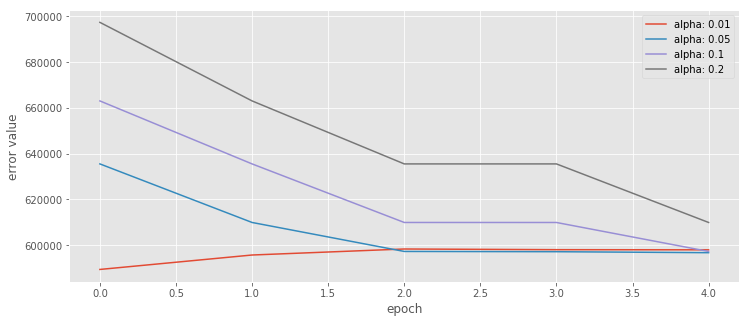

In [39]:
for alpha in (0.01, 0.05, 0.1, 0.2):
    model = MySGDClassifier(alpha=alpha, max_epoch=5, C=200)
    model.fit(X, y)
    plt.plot(model.errors, label='alpha: ' + str(alpha))
plt.ylabel('error value')
plt.xlabel('epoch')
plt.legend()

## Эффект регуляризации (2 балла)

Изобразите значения коэффициентов модели для каждого С из `np.logspace(3, -3, 10)` (желательно на одном и том же графике)

In [42]:
params = np.empty([10, X.shape[1]+1])
for i, c in enumerate(np.logspace(3, -3, 10)):
    model = MySGDClassifier(alpha=0.01, C=c, max_epoch=4)
    model.fit(X, y)
    params[i] = model.w

/home/emil/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/home/emil/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
/home/emil/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in multiply


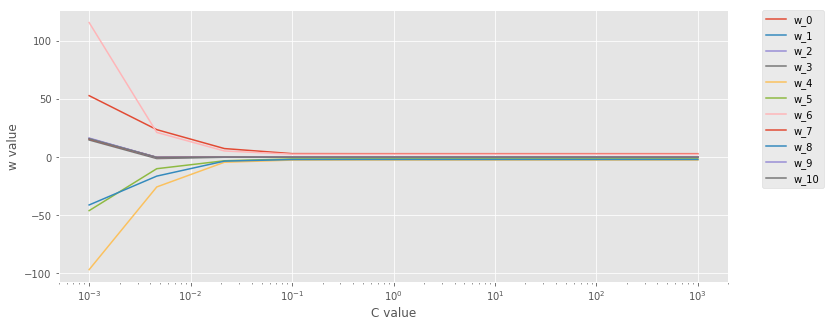

In [44]:
for i in range(params.shape[1]):
    plt.plot(np.logspace(3, -3, 10), params[:, i], label='w_' + str(i))
    plt.xscale('log')
plt.ylabel('w value')
plt.xlabel('C value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Боевое применение

## О hearthstone

[Hearthstone](http://eu.battle.net/hearthstone/ru/) - карточная он-лайн игра по мотивам вселенной Warcraft.

Каждый игрок играет за персонажа определенного класса и собирает колоду карт которую может разыгрывать во время игры. Для дальнейших деталей обратитесь к [wiki](https://ru.wikipedia.org/wiki/Hearthstone), посмотрите youtube или поиграйте сами (но не долго =) ).

Теми или иными способами игрок может отнимать жизни у своего оппонента, таким образом цель раунда - побить другого игрока.

<center><img src='http://ps3hits.ru/wp-content/uploads/2015/08/hearthstone-game-sshot-1.jpg'></center>

## Постановка задачи

В рамках конференции [AAIA 17](https://fedcsis.org/2017/aaia) было запущено [соревнование](https://knowledgepit.fedcsis.org/contest/view.php?id=120) по предсказанию исхода раунда в heartstone. 

Используя признаки, которые описывают текущее состояние раунда необходимо предсказать **вероятность** победы игрока в этом раунде.

Качество модели измеряется с помощью **ROC-AUC**

## Данные

Обучающую выборку и тестовую выборку с ответами можно скачать [отсюда](https://cloud.mail.ru/public/BEon/4Rrdqqvng)

Данные содержат набор информации о раунде в некоторый момент времени: жизни игрока и оппонента, номер хода, карты на столе, карты в руке игрока, количество карт в руке оппонента и тп.<br/>
По игроку №1 (далее просто **игрок**) помимо всего прочего известен набор карт "в руке".</br>
По игроку №2 (далее просто **оппонент**) эта информация отсутствует.</br>


В данных для обучению содержится 2 млн. игр, разбитых на 4 файла. Названия признаков говорят сами за себя.
Целевой признак - `decision` (1 - победил игрок, 0 - победил оппонент).

## Работа с простыми табличными данными (1 балл)

По соображениям сокращения времени вычислений, проделаем основные шаги по одной части данных.

Если все данные не будут помещаться вам с оперативную память, то можете использовать один из 4х файлов для обучения

In [45]:
# Загрузка данных целиком
# df_list = []
# for chunk in range(1,5):
#     filepath = './trainingData_tabular_chunk%d.csv' % chunk
#     df_list.append(pd.read_csv(filepath, sep=','))
# df_data = pd.concat(df_list)

# Загрузка одной части данных

filepath = './trainingData_tabular_chunk1.csv'
df_data = pd.read_csv(filepath, sep=',')

In [46]:
df_data.shape

(500000, 45)

In [47]:
# для удобства
df_data.columns = df_data.columns.str.replace('.', '_')
df_data = df_data.set_index('gamestate_id')

In [48]:
df_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hero_card_id,798,754,612,390,25
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1


In [49]:
# Распределение классов
df_data.decision.mean()

# Примерно поровну

0.504702

#### Задание

* Определите количество уникальных карт героя у игрока и оппонента.
* Преобразуйте категориальные переменные с помощью one-hot кодирования, добавьте к датасету и удалите прежние столбцы


In [50]:
opponent_unique_cards = df_data.opponent_hero_card_id.unique()
player_unique_cards = df_data.player_hero_card_id.unique()

print "unique opponent cards: ", len(opponent_unique_cards)
print "unique player cards: ", len(player_unique_cards)

unique opponent cards:  9
unique player cards:  9


In [51]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()

player_values_test = enc.fit_transform(
    df_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_unique_cards.shape[0] + 1)]
df_train_data = pd.concat([df_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_data.index)],
                           axis=1)

df_train_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [52]:
df_train_data.head().T

gamestate_id,4687346,3270826,3189487,4098946,2661127
decision,1,1,1,1,0
turn,14,7,5,8,13
opponent_armor,0,0,3,0,0
opponent_attack,0,0,0,0,0
opponent_hp,5,22,29,26,30
opponent_special_skill_used,0,0,0,0,0
opponent_weapon_durability,0,0,0,0,0
opponent_crystals_all,10,6,4,7,10
opponent_crystals_current,10,6,1,7,1
opponent_deck_count,11,19,22,17,12


## Обучение модели (1 балл)

#### Задание

* Получите матрицу объект признак `X` и вектор целевого признака `y`
* Создайте Pipeline из `StandartScaller` и вашей модели
* Обучите модель (подбирать гиперпараметры можно без фанатизма)

In [53]:
X = df_train_data.drop ('decision', axis=1)
y = df_train_data.decision.values

#model = MySGDClassifier(alpha=0.1, max_epoch=10, C=200, batch_size=10)
#model.fit (X, y)
#print model.w
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
model = MySGDClassifier(alpha=0.001, max_epoch=15, C=200)

scale_model = Pipeline([('scaler', scaler), ('model', model)])
scale_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('model', MySGDClassifier(C=200, alpha=1.5625e-05, max_epoch=15))])

## Применение модели (2 балла)
#### Задание
* Загрузите тестовые данные
* Подготовте их к подаче на вход в алгоритм
* Примените модель оцените качество с помощью меры ROC-AUC


In [ ]:
df_list = []
for chunk in range(5,7):
    filepath = './testData_tabular_chunk%d.csv' % chunk
    df_list.append(pd.read_csv(filepath, sep=','))
df_test_data = pd.concat(df_list)

In [55]:
df_test_data.shape

(1250000, 45)

In [56]:
df_test_data.columns = df_test_data.columns.str.replace('.', '_')
df_test_data = df_test_data.set_index('gamestate_id')
df_test_data.head().T

gamestate_id,1304374.0,4383331.0,3544947.0,4282915.0,4327924.0
decision,NaN,NaN,NaN,NaN,NaN
turn,5.0,9.0,16.0,3.0,5.0
opponent_armor,0.0,0.0,0.0,0.0,0.0
opponent_attack,0.0,3.0,0.0,0.0,0.0
opponent_hero_card_id,981.0,754.0,798.0,326.0,25.0
opponent_hp,23.0,16.0,16.0,30.0,30.0
opponent_special_skill_used,0.0,0.0,1.0,0.0,0.0
opponent_weapon_durability,0.0,1.0,0.0,0.0,0.0
opponent_crystals_all,4.0,8.0,10.0,2.0,4.0
opponent_crystals_current,0.0,3.0,2.0,2.0,1.0


In [ ]:
opponent_unique_cards = df_test_data.opponent_hero_card_id.unique ()
player_unique_cards = df_test_data.player_hero_card_id.unique ()

enc = OneHotEncoder()
player_values_test = enc.fit_transform(
    df_test_data.player_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

opponent_values_test = OneHotEncoder().fit_transform(
    df_test_data.opponent_hero_card_id.values.reshape(-1, 1)).toarray().astype(int)

player_columns = ["player_hero_card_id_" + "%d" % n for n in xrange(1, player_unique_cards.shape[0] + 1)]
opponent_columns = ["opponent_hero_card_id_" + "%d" % n for n in xrange(1, opponent_unique_cards.shape[0] + 1)]
df_test_modified_data = pd.concat([df_test_data,
                           pd.DataFrame(player_values_test, columns=player_columns,
                                        index=df_test_data.index),
                           pd.DataFrame(opponent_values_test, columns=opponent_columns,
                                        index=df_test_data.index)],
                           axis=1)

df_test_modified_data.drop(['opponent_hero_card_id', 'player_hero_card_id'], axis=1, inplace=True)

In [ ]:
X_test = df_test_modified_data.drop('decision', axis=1)

scores = model.predict_proba(X_test)
scores

In [2]:
from sklearn.metrics import roc_auc_score

y_test = np.loadtxt('deprecated_testLabels.txt')

print 'ROC_AUC:', roc_auc_score(y_test, scores)

ROC_AUC: 0.496008916071
